# Chapter 10 用Keras介绍人工神经网络

## Setup

In [1]:
# This project requires Python 3.7 or above
import sys

assert sys.version_info >= (3, 7)

In [2]:
# It also requires Scikit-Learn ≥ 1.0.1
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
# And TensorFlow ≥ 2.8
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
# As we did in previous chapters
# let's define the default font sizes to make the figures prettier
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
# create the images/ann folder
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [6]:
# define the save_fig() function 
# which is used through this notebook to save the figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1. 使用神经元的逻辑计算

人工神经元：它有一个或多个二进制（开/关）输入和一个二进制输出。当人工神经元的输入超过一定数量时，人工神经元激活其输出。

为了了解这样的网络是如何工作的，让我们构建一些执行各种逻辑计算的ann，假设一个神经元在至少有两个输入连接是激活的时被激活。

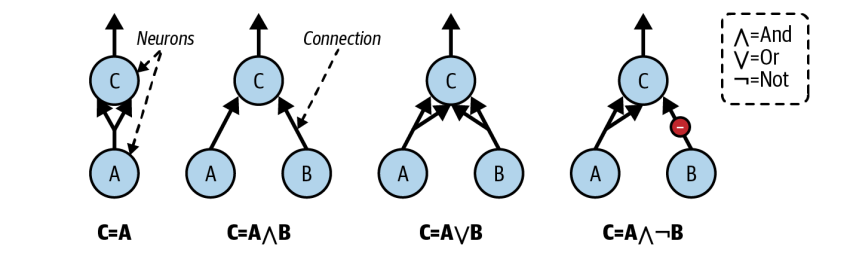

1. 左边的第一个网络是身份函数：如果神经元A被激活，那么神经元C也被激活（因为它接收到来自神经元A的两个输入信号）；但是如果神经元A是关闭的，那么神经元C也是关闭的。
2. 第二个网络执行一个逻辑的与：只有当神经元A和B都被激活时，神经元C才会被激活（单个输入信号不足以激活神经元C）。
3. 第三个网络执行一个合乎逻辑的OR：如果神经元A或神经元B被激活（或两者都被激活），神经元C就会被激活。
4. 最后，如果我们假设一个输入连接可以抑制神经元的活动（这是生物神经元的情况），那么第四个网络计算出一个稍微复杂一点的逻辑命题：只有当神经元A活跃，神经元B关闭时，神经元C才会被激活。如果神经元A一直是活跃的，那么你得到一个逻辑的NOT：当神经元B关闭时，神经元C是活跃的，反之亦然。

## 2. 感知器（The Perceptron）

**感知器是最简单的人工神经网络架构之一**：基于一个略有不同的人工神经元，称为阈值逻辑单元（TLU），有时也称为线性阈值单元（LTU）。

**TLU/LTU**:

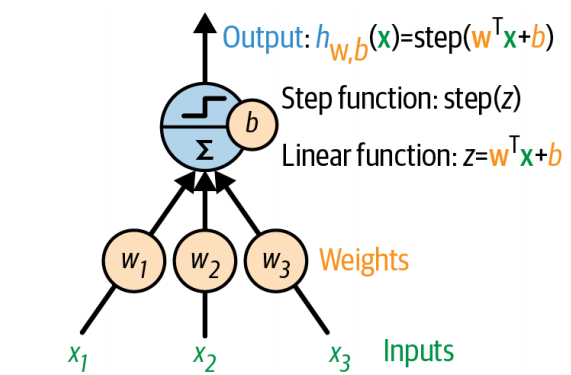

输入和输出都是数字（而不是二进制的开/关值），并且每个输入连接都与一个权重相关联。

1. Linear function：TLU首先计算其输入的线性函数 $z=w_1x_1+w_2x_2+...+w_nx_n+b=\pmb{w}^T\pmb{x}+b$ 
2. Step function：然后，它对结果应用了一个阶跃函数 $h_{\pmb{w}}(\pmb{x})=step(z)$

感知器中最常用的阶跃函数是Heaviside阶跃函数。有时会使用符号函数来代替。

感知器中使用的常见阶跃函数（假设阈值为0）

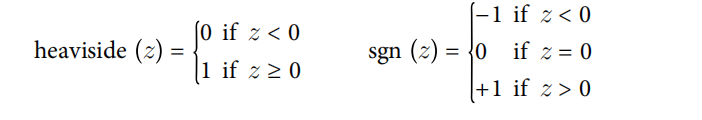

感知器由一个或多个单层中的TLU组成，每个TLU都连接到每个输入。这种层被称为完全连接的层，或稠密的层。输入构成了输入层。由于TLU的层产生最终的输出，所以它被称为输出层。

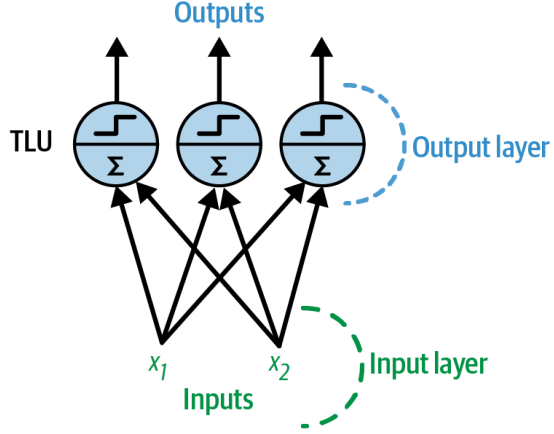

该感知器可以同时将实例分为三个不同的二进制类，这使其成为一个多标签分类器。它也可以用于多类分类。

由于线性代数的魔力，如下方程可以用来有效地同时计算多个实例中一层人工神经元的输出。

**计算一个完全连接的图层的输出**

$$h_{\pmb{W},\pmb{b}}(X)=\phi(\pmb{W^TX}+\pmb{b})$$

1. $\pmb{X}$ 表示输入特征的矩阵。它的每个实例有一行，每个特性有一列。
2. 权重矩阵 $\pmb{W}$ 包含了所有的连接权重。每个输入有一行，每个神经元有一列。
3. 偏置向量 $\pmb{b}$ 包含所有的偏倚项：每个神经元一个。
4. 函数 $\phi$ 被称为激活函数：当人工神经元是TLUs时，它是一个阶跃函数（我们稍后将讨论其他激活函数）。

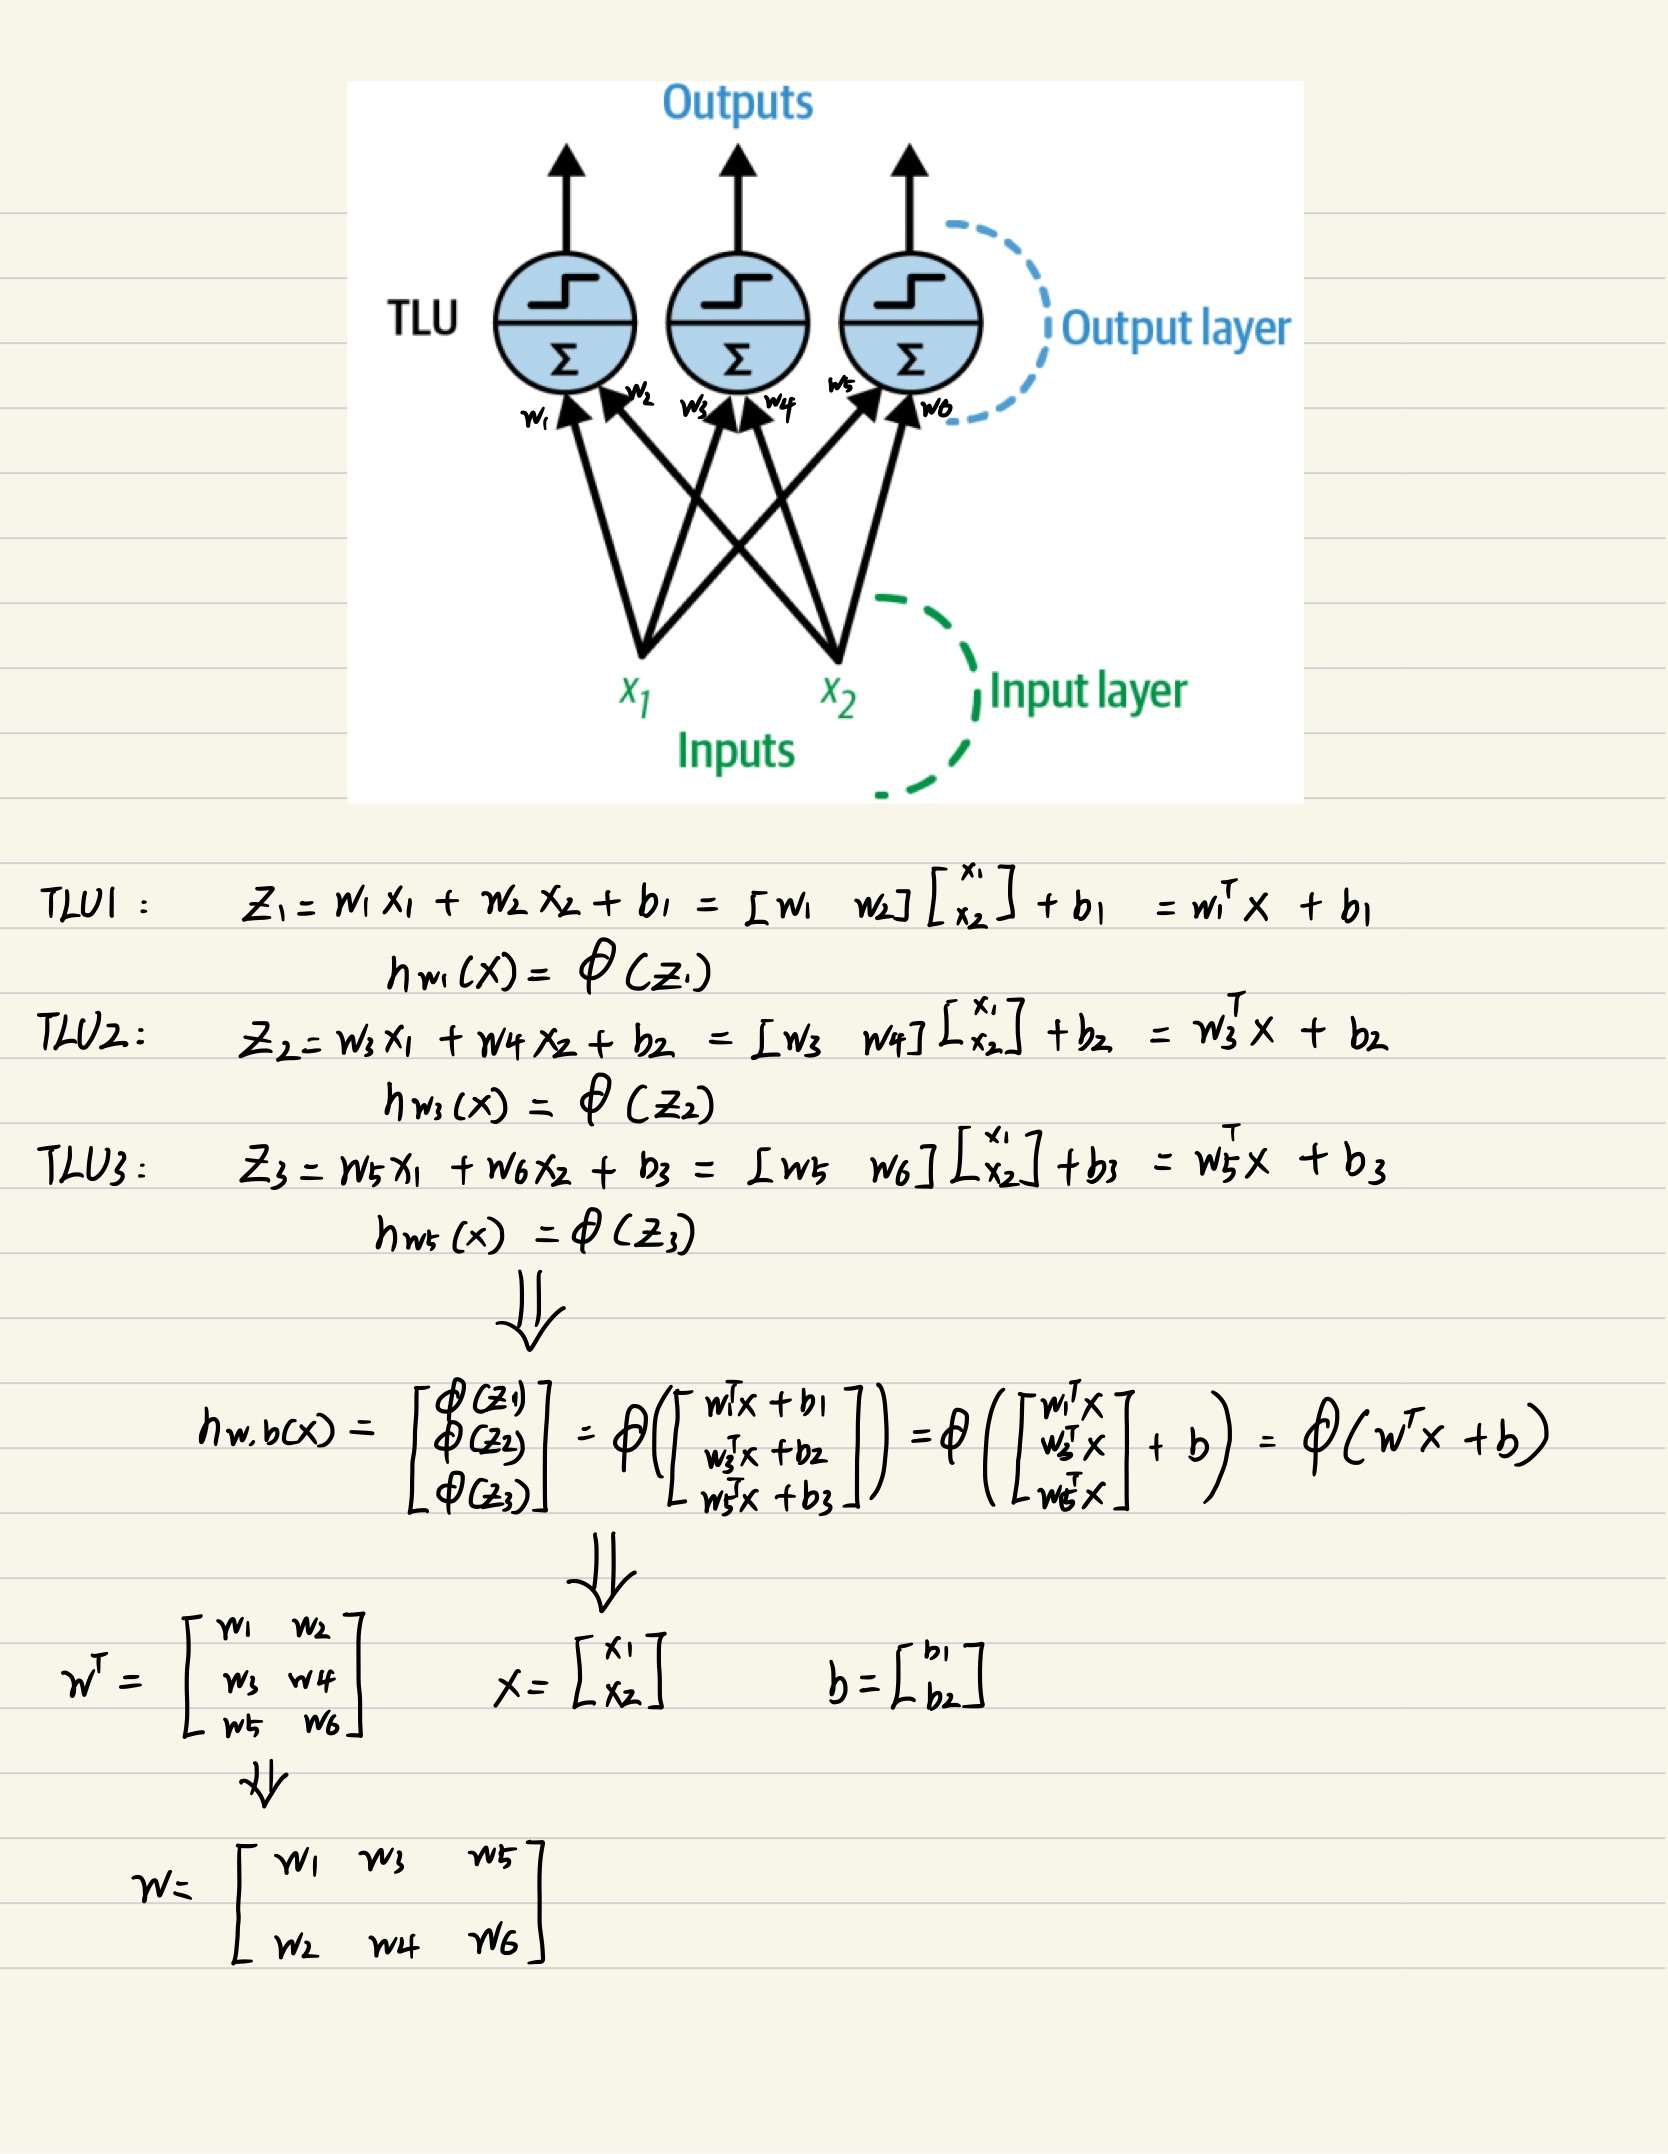

在数学中，一个矩阵和一个向量的和是不定义的。然而，在数据科学中，我们允许“广播”：向矩阵中添加一个向量意味着将其添加到矩阵中的每一行中。因此，$\pmb{W^TX} + \pmb{b}$ 首先将 $\pmb{W^T}$ 乘以 $\pmb{X}$ ——这得到一个矩阵，每个实例一行，每个输出一列矩阵——然后将向量 $\pmb{b}$ 添加到该矩阵的每一行，从而将每个偏差项添加到相关输出中。此外，$\phi$ 将被逐项应用于结果矩阵中的每个项。

**Hebb's rule (or Hebbian learning)**:唐纳德·赫布在他1949年出版的《行为组织（威利》一书）中提出，当一个生物神经元经常触发另一个神经元时，这两个神经元之间的联系就会变得更强。

罗森布拉特提出的感知器训练算法在很大程度上是受到了赫布规则的启发。也就是说，当两个神经元同时发射时，两个神经元之间的连接权重趋于增加。

感知器是使用该规则的一个变体进行训练的，该规则考虑到网络在做出预测时所犯的错误；感知器学习规则加强了有助于减少错误的联系。更具体地说，感知器一次被输入一个训练实例，并对每个实例做出预测。对于每一个产生错误预测的输出神经元，它会从输入中增强原本有助于正确预测的连接权重。

**Perceptron learning rule (weight update)**:

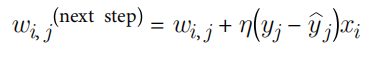

1. $w_{i,j}$ 是第i个输入与第j个神经元之间的连接权值。
2. $x_i$ 是当前训练实例的第i个输入值。
3. $\hat{y}_j$ 是当前训练实例的第j个输出神经元的输出。
4. $y_j$ 是当前训练实例的第j个输出神经元的目标输出。
5. $\eta$ 是学习率。

**感知器收敛定理**：每个输出神经元的决策边界都是线性的，因此感知器不能学习复杂的模式（就像逻辑回归分类器一样）。如果训练实例是线性可分的，罗森布拉特证明了该算法将收敛到一个解。

In [7]:
# Scikit-Learn provides a Perceptron class
import numpy as np
# on the iris dataset
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0) # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new) # predicts True and False for these 2 flowers

y_pred

array([ True, False])

**感知器学习算法非常类似于随机梯度下降**：事实上，Scikit-Learn的感知器类相当于使用具有以下超参数的SGD分类器：loss="perceptron"，learning_rate="constant"，eta0=1 (the learning rate)，penalty=None (no regularization)。

**感知器有一些严重弱点**：特别是，他们无法解决一些微不足道的问题（例如，排他性的OR（XOR）分类问题；参见下图左侧）。这对任何其他线性分类模型（如逻辑回归分类器）都是正确的。

但是结果表明，感知器的一些限制可以通过叠加多个感知器来消除。由此产生的人工神经网络被称为多层感知器（Multilayer Perceptrons, MLP）。MLP可以解决XOR问题，可以通过下图右侧表示的MLP的输出来验证：输入（0,0）或（1,1），网络输出0，输入（0、1）或（1,0）输出1。

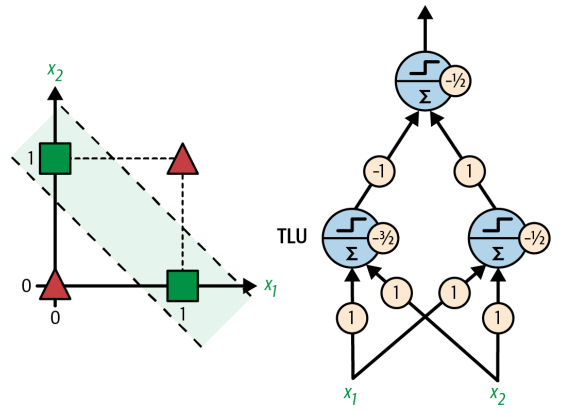

例如，当输入为（0,1）时，左下神经元计算0×1+ 1×1-3/2=-1/2，这是负的，所以它输出0。右下神经元计算0×1+1×1-1/2=1/2，这是正的，所以它输出1。输出神经元接收前两个神经元的输出作为其输入，因此它计算0×(-1)+1×1-1/2=1/2。这是正的，所以它输出为1。

## 3. 多层感知器和反向传播（The Multilayer Perceptron and Backpropagation）

一个MLP由一个**输入层**、一个或多个称为**隐藏层**的TLU层和最后一个称为**输出层**的TLU层组成。靠近输入层的层通常称为下层，而接近输出层的层通常称为上层。

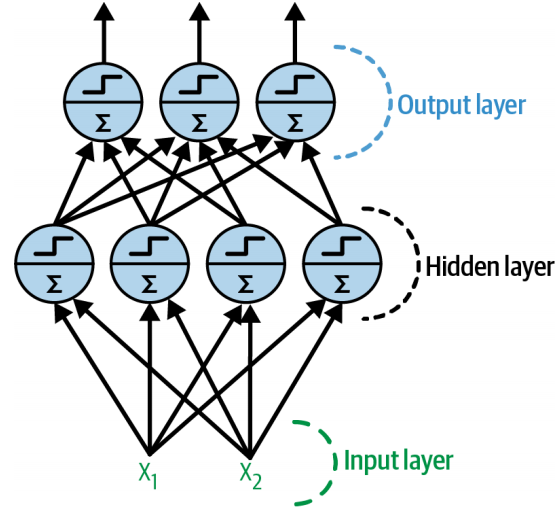

信号只在一个方向上流动（从输入到输出），所以这种结构是前馈神经网络（FNN）的一个例子。

当一个神经网络包含一个深层的隐藏层堆栈时，它被称为深度神经网络（DNN）。深度学习领域研究DNN，更普遍的是，它对包含深度计算堆栈的模型感兴趣。

1970年，一位名叫塞波·林奈玛的研究者在他的硕士论文中介绍了一种自动有效地计算所有梯度的技术。这种算法现在被称为**反向模式自动差分（或简称反向模式自动差分）**。只要通过两次网络（一个向前，一个向后），它就能够计算出神经网络对每个模型参数的误差梯度。然后，这些梯度可以用来执行一个梯度下降步骤。如果你重复这个自动计算梯度的过程，并采取一个梯度下降的步骤，神经网络的误差将逐渐下降，直到它最终达到一个最小值。这种反向模式自动消减和梯度下降的组合现在被称为**反向传播**。

反向传播实际上可以应用于各种计算图，而不仅仅是神经网络：事实上，林奈玛的硕士论文并不是关于神经网络的，而是更普遍的。又过了几年，反向传播才开始被用于训练神经网络，但它仍然不是主流。然后，在1985年，大卫·鲁梅尔-哈特、杰弗里·辛顿和罗纳德·威廉姆斯发表了一篇开创性的论文，分析了反向传播如何允许神经网络学习有用的内部表征。他们的研究结果是如此令人印象深刻，以至于反向传播很快就在该领域推广开来，是迄今为止最流行的神经网络训练技术。

**反向传播工作机制**：
1. 它一次处理一个mini-batch，并多次通过完整的训练集。每一次都被称为一个epoch。
2. 每个mini-batch都通过输入层进入网络。然后，对于mini-batch中的每个实例，该算法计算第一个隐藏层中所有神经元的输出。结果被传递到下一层，被计算后传递到下一层，以此类推，直到我们得到最后一层的输出，即输出层。这是正向传递：它就像做预测一样，除了所有的中间结果都被保留了下来，因为它们是反向传递所需要的。
3. 接下来，该算法度量网络的输出误差，即使用一个损失函数来比较期望的输出和网络的实际输出，并返回一些误差的度量。
4. 然后计算每个输出偏差和每个到输出层的连接对误差的贡献。这是通过应用链式法则来解析地完成的，这使得这一步快速而精确。
5. 然后该算法测量有多少这些错误贡献来自下面一层中的每个连接，同样使用链规则，向后工作，直到到达输入层。这种反向传递通过通过网络反向传播误差梯度（因此被称为算法），有效地测量了网络中所有连接权值和偏差之间的误差梯度。
6. 最后，该算法利用刚刚计算出的误差梯度，执行一个梯度下降步骤来调整网络中的所有连接权值。

随机初始化所有隐藏层的连接权值是很重要的，否则训练就会失败。例如，如果你将所有的权值和偏差初始化为零，那么给定层中的所有神经元都将是完全相同的，因此反向传播将以完全相同的方式影响它们，因此它们将保持相同。换句话说，尽管每层有数百个神经元，但模型会表现得好像每层只有一个神经元：它不会太聪明。如果随机初始化权值，就打破对称，允许反向传播来训练不同的神经元。

**为了使反向传播正常工作，Rumelhart和他的同事对MLP的架构做了一个关键的改变**：用逻辑函数 $\sigma(z)=1/(1+(exp(-z))$ 取代了阶梯函数，也称为**sigmoid function**。这是至关重要的，因为**step funtcion**只包含平面段，所以没有梯度来工作（梯度下降不能在平面上移动），而s型函数到处都有一个定义良好的非零导数，允许梯度下降在每一步都取得一些进展。

事实上，反向传播算法可以很好地与许多**其他激活函数**一起工作，而不仅仅是s型函数。以下是另外两个流行的选择：
1. 双曲切线函数(hyperbolic tangent function)：$tanh(z)=2\sigma(2z)-1$。就像S型函数（Sigmoid function）一样，这个激活函数是S形的，连续的，可微的，但它的输出值范围从-1到1（而不是在sigmoid function的情况下从0到1）。这个范围往往会使每一层的输出在训练开始时或多或少以0为中心，这通常有助于加速收敛。
2. 整流后的线性单位函数(rectified linear unit function)：$RelU(z)=max(0,z)$。ReLU函数是连续的，但不幸的是，在 $z=0$ 处不可微（斜率突然变化，这可能会使梯度下降反弹），对于 $z<0$ ，它的导数为0。然而，在实践中，它工作得很好，并且具有快速计算的优势，因此它已经成为默认值。重要的是，它没有最大输出值的事实有助于减少梯度下降过程中的一些问题

**为什么我们首先需要激活函数?**

如果你链接了几个线性变换，你得到的只是一个线性变换。例如，如果 $f(x)=2x+3$ 和 $g(x)=5x-1$ ，那么将这两个线性函数链接得到另一个线性函数：$f(g(x))=2(5x-1)+3=10x+1$ 。所以，如果层之间没有一些非线性，那么即使是一个很深的层堆栈也相当于单个层，你不能为此解决非常复杂的问题。相反地，一个足够大的具有非线性激活的DNN在理论上可以近似于任何连续函数。

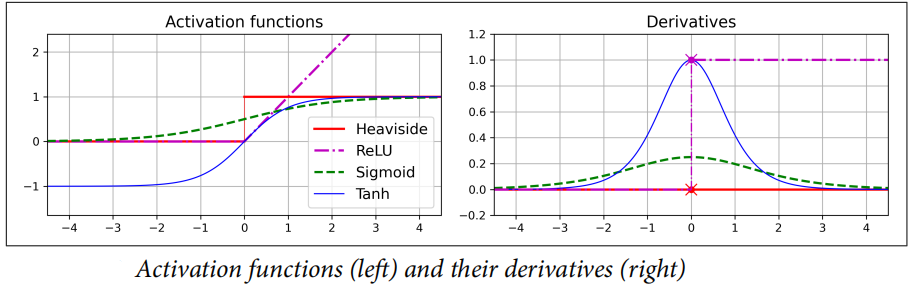

## 4. 回归MLPs（Regression MLPs）

首先，MLPs可以用于回归任务。如果你想预测一个单一的值，那么你只需要一个输出神经元：它的输出就是预测值。对于多元回归（一次预测多个值），每个输出维度需要一个输出神经元。

Scikit-Learn包括一个MLP回归类，所以让我们用它来构建一个MLP，三个隐藏层，每个隐藏层由50个神经元组成，并在加州住房数据集上对其进行训练。

In [8]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

# 75%测试集，25%训练集
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                              housing.target,
                                                              random_state=42)
# 75%测试集，25%验证集
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, 
                                                      y_train_full, 
                                                      random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)

# squared=False 计算RMSE，否则默认计算MSE
rmse = mean_squared_error(y_valid, y_pred, squared=False)

rmse

0.5053326657968528

注意这个MLP没有对输出层使用任何激活函数，因此它可以自由地输出任何它想要的值。这通常是好的，但如果想保证输出总是正的，那么应该在输出层中使用ReLU激活函数，或softplus激活函数，这是ReLU的平滑变体：$softplus(z)=log(1+exp(z))$ 。当 $z$ 为负时，softplus接近于0，当z为正时接近于z。

最后，如果想保证预测总是在给定的值范围内，那么你应该使用s型函数或双曲切线，并将目标缩放到适当的范围：s型为0到1，tanh为-1到1。

遗憾的是，MLPRegressor类不支持输出层中的激活函数。使用Scikit来构建和训练一个标准的MLP——只需用几行代码就可以学习是非常方便的，但神经网络的特性是有限的。这就是为什么将在本章的第二部分转向Keras。

**典型的回归MLP架构**:
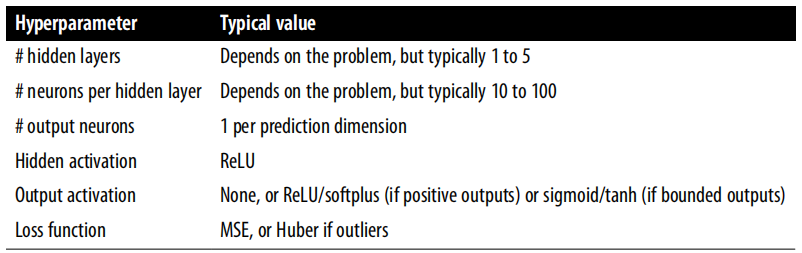

MLPRegressor类使用均方误差MSE，这通常是你想要的回归，但是如果你在训练集中有很多异常值，你可能更喜欢使用平均绝对误差来代替。或者，您可能想要使用Huber损失，这是两者的结合。当误差小于阈值 $\delta$（通常为1）时，它是二次型的，但当误差大于 $\delta$ 时，它是线性的。线性部分与均方误差相比，它对异常值更不那么敏感，二次部分使它比平均绝对误差收敛得更快、更精确。然而，mlp预测器只支持MSE。

## 5. 分类MLPs（Classification MLPs）

**MLPs也可以用于分类任务**：

1. 对于**二分类**问题，只需要一个使用 sigmoid 激活函数的单一输出神经元：输出将是一个介于0到1之间的数字，您可以将其解释为正类的估计概率。负类的估计概率等于1减去这个数字。
2. MLPs还可以轻松地处理**多标签二分类**任务。例如，您可以有一个电子邮件分类系统，它可以预测每封收到的电子邮件是垃圾邮件还是垃圾邮件，并同时预测它是紧急电子邮件还是非紧急电子邮件。在这种情况下，将需要两个输出神经元，都使用 sigmoid 激活函数：第一个将输出电子邮件是垃圾邮件的概率，第二个将输出它是紧急的概率。
3. 对于**多分类**任务，也就是说在三个或更多可能的类（例如，类0到9）的情况下，每个实例只能属于一个类，那么就需要每个类有一个输出神经元，并且您应该对整个输出层使用softmax激活函数。softmax函数将确保所有估计概率在0到1之间，并且加起来为1，因为类是排他的。

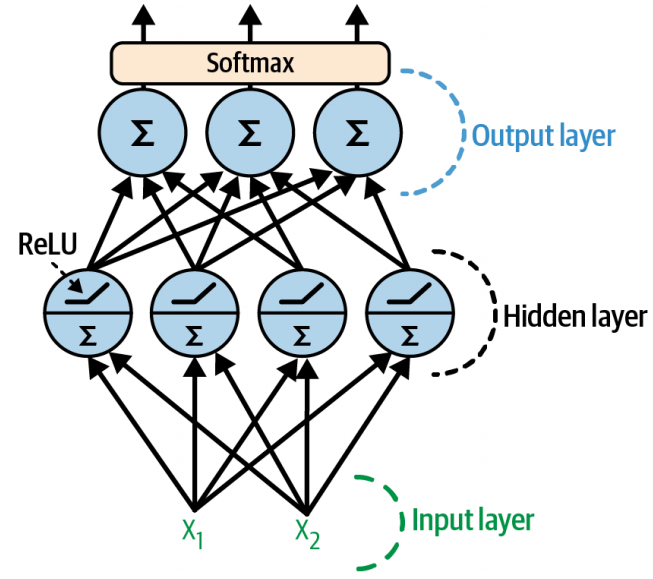

关于损失函数，由于我们预测的是概率分布，**交叉熵损失函数（cross-entropy loss）** 通常是一个很好的选择。

Scikit-Learn在sklearn.neural_network包中有一个MLP分类器类。它几乎与MLP回归类相同，除了它最小化了交叉熵，而不是MSE。

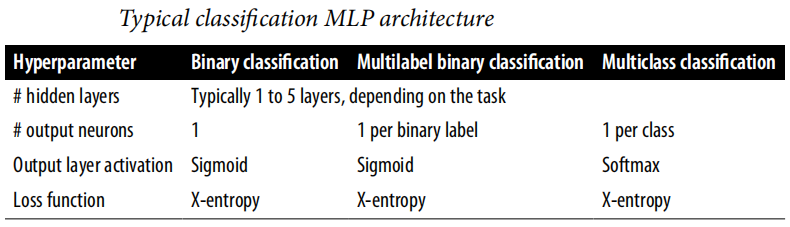

## 6. 使用Keras实现MLP（Implementing MLPs with Keras）

**Keras**是TensorFlow的高级深度学习API：它允许您构建、训练、评估和执行各种神经网络。

Keras过去用来支持多个后端，包括TensorFlow、PlaidML、Theano和微软认知工具包（Microsoft Cognitive Toolkit, CNTK）（最后两个不幸被弃用），但由于2.4版本，Keras只支持TensorFlow。类似地，TensorFlow过去曾包含多个高级API，但当TensorFlow2出现时，Keras被正式选为其首选的高级API。安装TensorFlow也会自动安装Keras，并且如果没有安装TensorFlow，Keras将无法工作。

## 7. 使用sequential API构建图像分类器（Building an Image Classifier Using the Sequential API）

对于数据集，我们将使用Fashion MNIST，是一个关于MNIST可以随时使用的替代数据集，它的格式与MNIST完全相同（70000张灰度图像，每个28×28像素，10个类），但图像代表fashion items而不是手写数字，所以每个类都更多样化，问题比MNIST更具挑战性。

### 7.1 使用Keras来加载数据集（Using Keras to load the dataset）

Keras提供了一些实用程序函数来获取和加载公共数据集，包括MNIST、Fashion MNIST等。加载Fashion MNIST，它已经被打乱成一个训练集（60000张图像）和一个测试集（10000张图像），但我们将保留训练集中的最后5000张图像进行验证：

In [9]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

当使用Keras而不是Scikit-Learn加载MNIST或Fashion MNIST时，一个重要的区别是，每张图像都被表示为一个28×28数组，而不是一个大小为784的1D数组。此外，像素强度被表示为整数（从0到255），而不是浮点数（从0.0到255.0）。让我们来看看训练集的形状和数据类型：

In [10]:
 X_train.shape

(55000, 28, 28)

In [11]:
 X_train.dtype

dtype('uint8')

为简单起见，我们将像素强度除以255.0，将其转换为0-1范围（这也将它们转换为浮点数）：

In [12]:
# 自变量从0-255转换为0-1范围
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

对于Fashin MNIST，我们需要类名列表来知道我们正在处理什么：

In [13]:
# Fashion MNIST 类名列表
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
 "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

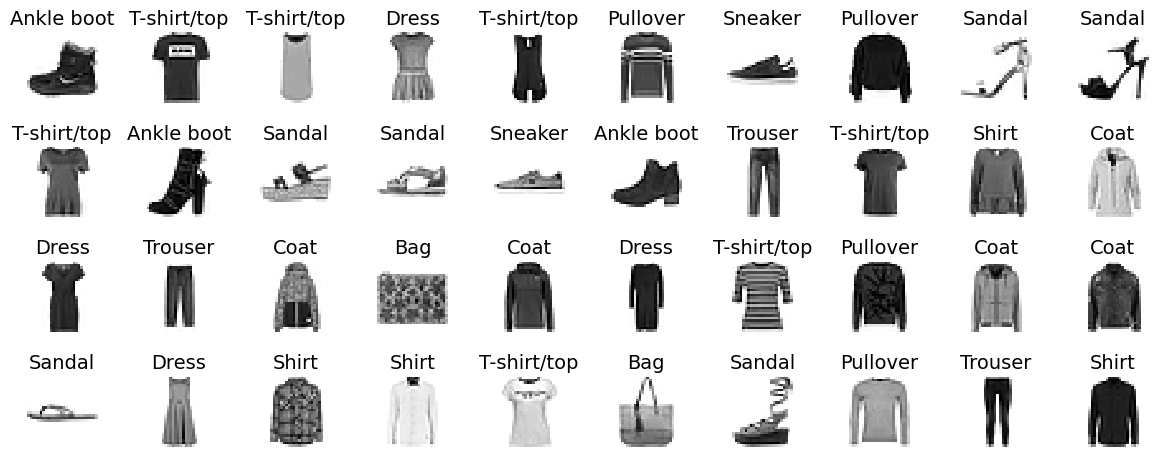

In [14]:
# 显示了来自Fashion MNIST数据集的一些示例

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

In [15]:
# the first image in the training set represents an ankle boot
class_names[y_train[0]]

'Ankle boot'

### 7.2 使用sequential API创建模型（Creating the model using the sequential API）

In [16]:
# create classification MLP with two hidden layers
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

1. 首先，设置TensorFlow的随机种子，使结果具有可重复性：每次运行notebook时，隐藏层和输出层的随机权重将是相同的。还可以选择使用tf.keras.utils.set_random_seed()函数，它可以方便地为TensorFlow、Python（random.seed()）和NumPy（np.random.seed()）设置随机种子。
2. 下一行将创建了一个顺序模型。这是神经网络中最简单的Keras模型，它只是由一个顺序连接的层组成。这叫做顺序API。
3. 接下来，我们构建第一层（一个输入层），并将其添加到模型中。我们指定了输入形状，它不包括批处理大小，只包括实例的形状。Keras需要知道输入端的形状，这样才能确定第一个隐藏层的连接权重矩阵的形状。
4. 然后我们添加一个Flatten layer。它的作用是将每个输入图像转换为一个一维数组：例如，如果它接收到一批形状[32,28,28]，它将将其重塑为[32,784]。换句话说，如果它接收到输入数据X，它将计算X.reshape(-1,784)。这一层没有任何参数；它只是为了做一些简单的预处理。
5. 接下来，我们添加了一个包含300个神经元的密集隐藏层。它将使用ReLU激活功能。每个密集层都管理着自己的权值矩阵，其中包含神经元与其输入之间的所有连接权值。它还管理着一个偏差项的向量（每个神经元一个）。
6. 然后我们添加第二个包含100个神经元的密集隐藏层，也使用ReLU激活函数。
7. 最后，我们添加了一个包含10个神经元的密集输出层（每个类一个），使用softmax激活函数，因为这些类是排他性的。

不要像我们在创建顺序模型时那样，通常通过一个图层列表来逐个添加图层。也可以删除输入层，而不是在第一层中指定input_shape：

In [17]:
model = tf.keras.Sequential([
 tf.keras.layers.Flatten(input_shape=[28, 28]),
 tf.keras.layers.Dense(300, activation="relu"),
 tf.keras.layers.Dense(100, activation="relu"),
 tf.keras.layers.Dense(10, activation="softmax")
])

模型的 **summary()** 方法显示了模型的所有层，包括每个层的名称（除非您在创建层时设置它，否则它是自动生成的），它的输出形状（None表示批大小可以是任何东西），以及它的参数数量。摘要以参数的总数结束，包括可训练参数和不可训练参数。这里我们只有可训练的参数（将在之后看到一些不可训练的参数）：

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


**注意密集的层通常有很多参数**。

例如，第一个隐藏层有784个×300个连接权值，加上300个偏差项，这加起来有235500个参数！这给模型提供了相当大的灵活性来拟合训练数据，但这也意味着模型存在过拟合的风险，特别是当您没有大量的训练数据时。稍后会再讲到这个问题。

模型中的每一层都必须有一个唯一的名称。这使得我们可以很容易地合并模型，而不会出现名称冲突。

您可以使用**layers**属性轻松获得模型的图层列表，或者使用**get_layer()** 方法按名称访问图层：

In [19]:
model.layers

In [20]:
model.get_layer("dense_3")

一个层的所有参数都可以使用它的 **get_widers()** 和 **set_widers()** 方法来访问。对于密集层，这包括连接权值和偏差项：

In [21]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()

In [22]:
weights

array([[ 0.04026505,  0.0336908 ,  0.06203449, ..., -0.03496262,
         0.01018538, -0.01285601],
       [ 0.02119172,  0.06003276, -0.01665634, ...,  0.04022883,
         0.02719979, -0.00527806],
       [-0.00923447,  0.04211004,  0.04372424, ...,  0.04173935,
         0.04172213, -0.05358648],
       ...,
       [-0.04491626, -0.03929373,  0.05598891, ..., -0.05916878,
         0.02974807, -0.06229364],
       [ 0.01120211,  0.05728196,  0.04914934, ..., -0.06317712,
         0.02914507,  0.01338681],
       [-0.00576358, -0.04592903,  0.00939253, ...,  0.06831451,
        -0.05982756, -0.06619247]], dtype=float32)

In [23]:
weights.shape

(784, 300)

In [24]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [25]:
biases.shape

(300,)

请注意，密集层随机地初始化了连接权值（如前面所述，这需要打破对称性），并且偏差被初始化为零。

如果您想使用不同的初始化方法，您可以在创建图层时设置kernel_initializer（内核是连接权重矩阵的另一个名称）或bias_initializer。将在第11章中进一步讨论初始化器。

**注意**：权重矩阵的形状取决于输入的数量，这就是为什么我们在创建模型时指定了input_shape。如果您没有指定输入形状，这是可以的： Keras只会等到它知道输入形状后再实际构建模型参数。当您提供它一些数据时（例如，在训练期间），或者当您调用其build()方法时，都会发生这种情况。但是在构建模型参数之前，您将无法执行某些事情，例如显示模型摘要或保存模型。因此，如果您在创建模型时知道输入形状，那么最好指定它。

### 7.3 编译模型（Compiling the model）

创建模型后，必须调用它的 **compile()** 方法来指定要使用的损失函数和优化器。您可以指定在训练和评估期间计算的额外度量列表：

In [26]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

使用 **loss="sparse_categorical_crossentropy"** 等价于使用 **loss=tf.keras.losses.sparse_categorical_crossentropy** 。类似地，使用 **optimizer="sgd"** 等价于使用 **optimizer=tf.keras.optimizers.SGD（）** ，使用 **metrics=\["accuracy"\]** 相当于使用 **metrics=\[tf.keras.metrics.sparse_categorical_accuracy\]** 。

**代码的解释**:

1. 我们使用“sparse_categorical_crossentropy”损失是因为我们有稀疏的标签（即，对于每个实例，只有一个目标类索引，在这种情况下从0到9），并且类是排他的。相反，如果每个实例的每个类都有一个目标概率(例如独热向量，例如，\[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.\]为了表示类3)，那么我们将需要使用“categorical_crossentropy”损失来代替。如果我们做二分类或多标签二分类，那么我们将在输出层使用“sigmoid”激活函数，而不是“softmax”激活函数，我们将使用“binary_crossentropy”损失。如果您想将稀疏标签（即类索引）转换为独热标签，使用 **tf.keras.utils.to_categorical()** 。要相反，使用 **axis=1** 的 **np.argmax()** 。
2. 对于优化器，“sgd”意味着我们将使用随机梯度下降来训练模型。换句话说，Keras将执行反向传播算法（即，反向模式的自动分割加上梯度下降）。当使用SGD优化器时，调整学习速率是很重要的。因此，通常会希望使用 **optimizer=tf.keras.optimizers.SGD(learn_rate=__???__)** 来设置学习速率，而不是 **optimizer="sgd"** ，它默认的学习速率为0.01。将在第11章中讨论更有效的优化器。它们改善了梯度下降，而不是自动下降。
3. 最后，由于这是一个分类器，所以在训练和评估过程中测量它的准确性是很有用的，这就是为什么我们设置 **metrics=["accuracy"]** 。

### 7.4 训练和评估该模型（Training and evaluating the model）

In [27]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7012 - accuracy: 0.7726 - val_loss: 0.4971 - val_accuracy: 0.8324
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4820 - accuracy: 0.8328 - val_loss: 0.4536 - val_accuracy: 0.8370
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4356 - accuracy: 0.8470 - val_loss: 0.4187 - val_accuracy: 0.8514
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4115 - accuracy: 0.8560 - val_loss: 0.3954 - val_accuracy: 0.8620
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3916 - accuracy: 0.8625 - val_loss: 0.3882 - val_accuracy: 0.8602
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3758 - accuracy: 0.8667 - val_loss: 0.3961 - val_accuracy: 0.8608
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3641 - accuracy: 0.8706 - val_loss: 0.3695 - val_accuracy:

我们传递给它 **input features（X_train）** 和 **target class（y_train）** ，以及要训练的 **epochs**（否则它将默认为1）。我们还通过了一个验证集（这是可选的）。Keras将在每个epoch结束时测量这个集合上的损失和额外的度量值，这对于查看模型的实际表现非常有用。**如果训练集上的性能比验证集上好得多，那么您的模型可能是训练集的过拟合，或者存在一个错误，比如训练集和验证集之间的数据不匹配。**

例如形状错误是很常见的，特别是在开始的时候，所以你应该熟悉错误信息：试着用错误的输入和/或错误形状的标签来安装一个模型，然后看看你得到的错误。类似地，尝试用 loss="categorical_crossentropy" 而不是 loss="sparse_categorical_crossentropy" 来编译模型。或者你可以删除 Flatten layer。

就这样这个神经网络被训练好了。在训练期间的每个阶段，Keras都会在进度条的左侧显示到目前为止处理的小批次的数量。默认批大小为32，由于训练集有55000张图像，模型每个epoch历经过1719批：1718个大小为32,1个大小为24(共55000覆盖训练集)。在进度条之后，您可以看到每个样本的平均训练时间，以及在训练集和验证集上的损失和准确性（或您要求的任何其他额外指标）。请注意，训练损失下降了，这是一个很好的迹象，在30个epoch后，验证准确率达到了88.94%。这略低于训练精度，所以有一点过拟合，但不是很大。

可以设置 **validation_split** 为训练集中测试集的比率，而不是设置 **validation_data** 参数传递一个测试集。例如，validation_split=0.1 告诉Keras使用最后10%的数据（在洗牌之前）进行验证。

如果训练集非常 **skewed** ，有些类被 **overrepresented** ，而有些类被 **underrepresented** ，那么在调用 fit() 方法时设置 **class_weight** 参数将是有用的，给underrepresented的类更大的权重，给overrepresented的类更小的权重。

Keras在计算损失时将使用这些权重。如果需要每个实例的权重，请设置 sample_weight 参数。如果同时提供了 class_weight 和 sample_weight ，那么Keras将对它们进行多重组合。

每个实例的权重可能是有用的，例如，如果一些实例是被专家标记的，而另一些实例则是使用众包平台标记的：你可能想要给前者更多的权重。您还可以为验证集提供样本权重（但不是类权重），通过将它们添加到 validation_data 元组中的第三项。

**fit()** 方法返回一个 **History** 对象，其中包含训练参数（**history.params**）、它经历的epoch列表（**history.epoch**），最重要的是一个包含损失和额外指标的字典（**history.history**），它在每个epoch结束时对训练集和验证集（如果有的话）进行测量。

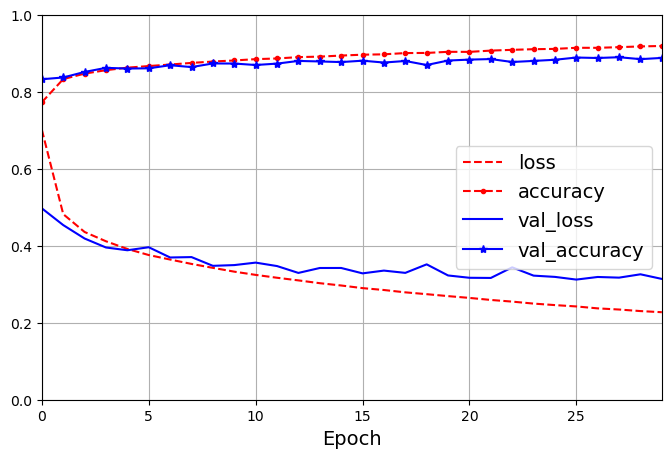

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
 figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
 style=["r--", "r--.", "b-", "b-*"])
plt.show()

在训练过程中，训练精度和验证精度都在训练期间稳步增加，而训练损失和验证损失则在减少。验证曲线一开始相对接近，但随着时间的推移，它们相距更远，这表明存在一点过拟合。

在这种特殊情况下，模型在训练开始时在验证集上比在训练集上表现得更好，但实际上并非如此。验证误差在每个epoch结束时计算，而训练误差在每个epoch期间使用运行平均值计算，因此训练曲线应该向左偏移半epoch。如果你这样做了，你就会看到训练曲线和验证曲线在训练开始时几乎完美地重叠。

训练集的性能最终超过验证性能，通常是训练足够长的情况。可以看出模型还没有完全收敛，因为验证损失还在下降，所以可能应该继续训练。这就像再次调用 fit() 方法一样简单，因为Keras只是在它停止的地方继续训练：你应该能够达到大约89.8%的验证精度，而训练精度将继续上升到100%。

如果对模型的性能不满意，那么应该返回并调优超参数。第一个要检查的是 **学习率** 。如果这没有帮助，尝试另一个 **优化器**（并总是在改变任何超参数后重新调整学习速率）。如果性能仍然不是很好，那么尝试调整模型超参数，如 **层数**、**每层神经元数量**以及每个隐藏层使用的**激活函数类型**。您还可以尝试调整其他超参数，例如**批处理大小**（它可以在 **fit()** 方法中使用 **batch_size** 参数进行设置，默认为32）。我们将在本章的最后回到超参数调优。一旦您对模型的验证精度感到满意，您就应该在测试集上对其进行评估，以便在将模型部署到生产中之前估计泛化误差。您可以使用 **evaluate()** 方法做到这些（它还支持其他几个参数，如 batch_size 和 sample_weight）：

In [29]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3279 - accuracy: 0.8826


[0.3279078006744385, 0.8826000094413757]

通常在测试集比验证集得到略低的性能，因为超参数调整验证集，而不是测试集（然而，在本例中，我们没有做任何超参数调整，所以较低的精度只是运气不好）。记住要抵制在测试集上调整超参数的诱惑，否则你对泛化误差的估计会过于乐观。

### 7.5 使用该模型来进行预测（Using the model to make predictions）

现在让我们使用模型的 **predict()** 方法来对新的实例进行预测。由于我们没有实际的新实例，所以我们将只使用测试集的前三个实例：

In [30]:
X_new = X_test[:3]
    
y_proba = model.predict(X_new)

y_proba.round(2)

1/1 [==============================] - 0s 65ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

如果只关心具有最高估计概率的类（即使这个概率相当低），那么您可以使用 **argmax()** 方法来获得每个实例的最高概率类索引：

In [31]:
import numpy as np

# axis=-1 means the last demension
y_pred = y_proba.argmax(axis=-1)

y_pred

array([9, 2, 1], dtype=int64)

In [32]:
# the classifier actually classified all three images correctly
y_new = y_test[:3]

y_new

array([9, 2, 1], dtype=uint8)

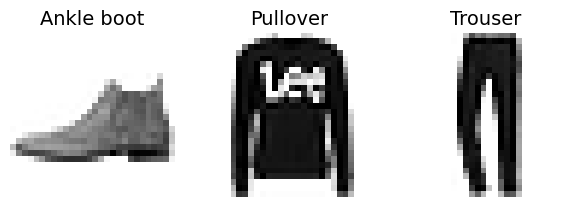

In [33]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## 8. 使用顺序API构建一个回归MLP（Building a Regression MLP Using the Sequential API）

让我们回到加州住房问题，用之前相同的MLP来解决它，3层，每个由50个神经元组成，但这次是用Keras构建它。

In [34]:
# 加载加州住房问题数据集
housing = fetch_california_housing()

# 75%测试集，25%训练集
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                              housing.target,
                                                              random_state=42)
# 75%测试集，25%验证集
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, 
                                                      y_train_full, 
                                                      random_state=42)

print(X_train.shape)
print(y_train.shape)

(11610, 8)
(11610,)


In [35]:
tf.random.set_seed(42)

# X_train.shape[1:] == (8,)
# in this example we don’t need a Flattenlayer
# instead we're using a Normalization layer as the first layer
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])

# output layer has a single neuron (since we only want to predict a single value)
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])

# we’re using an Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# the loss function is the mean squared error
# the metric is the RMSE
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

# before you call the model’s fit() method
# it must be fitted to the training data using its adapt() method 
norm_layer.adapt(X_train)

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

mse_test, rmse_test = model.evaluate(X_test, y_test)

X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7753 - root_mean_squared_error: 0.8805 - val_loss: 0.4580 - val_root_mean_squared_error: 0.6768
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3802 - root_mean_squared_error: 0.6166 - val_loss: 1.6911 - val_root_mean_squared_error: 1.3004
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3680 - root_mean_squared_error: 0.6066 - val_loss: 0.3415 - val_root_mean_squared_error: 0.5844
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3359 - root_mean_squared_error: 0.5796 - val_loss: 1.0940 - val_root_mean_squared_error: 1.0460
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3239 - root_mean_squared_error: 0.5691 - val_loss: 0.9787 - val_root_mean_squared_error: 0.9893
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3154 - root_mean_squared_error: 0.5616 - val_loss: 0.3022 - val_

当调用 **adapt()** 方法时，Normalization layer将学习训练数据中的特征均值和标准差。然而，当您显示模型的摘要时，这些统计数据将被列为不可训练的。这是因为这些参数不受梯度下降的影响。

## 9. 使用功能API构建复杂的模型（Building Complex Models Using the Functional API）

正如所看到的，**sequential API** 非常干净和直接。然而，尽管Sequential models非常常见，但有时构建具有更复杂的拓扑结构，或具有多个输入或输出的神经网络是有用的。为此目的，Keras提供了 **functional API**。

非序列神经网络的一个例子是 Wide&Deep neural network。这种神经网络结构是由2016年的一篇论文中介绍的，它将全部或部分输入直接连接到输出层。这种体系结构使神经网络可以同时学习深度模式（使用深度路径）和简单的规则（通过短路径）。

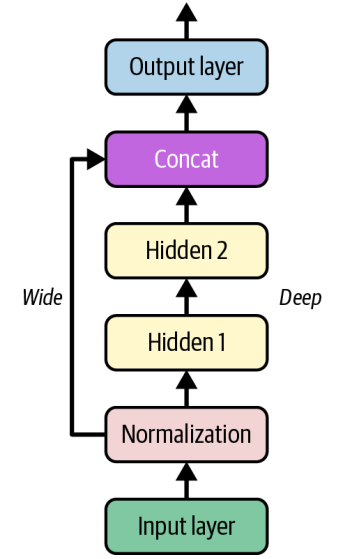

相比之下，规则的MLP迫使所有数据流过整个层的堆栈；因此，数据中的简单模式最终可能会被这一转换序列所扭曲。

**让我们建立这样一个神经网络来解决加州的住房问题**：

In [40]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

前五行创建所有的层我们需要构建模型，接下来的六行使用这些层就像函数从输入到输出，和最后一行创建一个Keras模型对象通过指向输入和输出。

**让我们更详细地介绍一下这段代码**：
1. 首先，我们创建了五个层：一个 Normalization layer 来标准化输入，两个 Dense layers ，每个层有30个神经元，使用ReLU激活函数，一个 Concatenate layer ，和一个 Sense layer ，输出层有单个神经元，没有任何激活函数。
2. 接下来，我们创建一个输入对象（变量名input_用于避免覆盖Python的内置 input() 函数）。这是模型将获得的输入类型的一个规范，包括它的shape和可选的dtype，它默认为32位浮点数。一个模型实际上可能有多个输入，很快就会看到。
3. 然后我们像使用函数一样使用 Normalization layer ，传递输入对象。这就是为什么这被称为 functional API 。请注意，我们只是告诉Keras如何将图层连接在一起；目前还没有处理实际的数据，因为输入对象只是一个数据规范。换句话说，这是一个象征性的输入。这个调用的输出也是符号性的：normalized 不存储任何实际数据，它只是用于构建模型。
4. 以同样的方式，然后我们将 normalized 传递给 hidden_layer1 ，它输出 hidden1 ，然后我们将 hidden1 传递给 hidden_layer2 ，它输出 hidden2。
5. 到目前为止，我们已经依次连接了这些层，但然后我们使用 concat_layer 来连接输入和第二个隐藏层的输出。同样，还没有实际的数据被连接起来：它都是象征性的，以构建模型。
6. 然后我们将 concat 传递到 output_layer ，从而得到最终的输出。
7. 最后，我们创建一个Keras模型，指定要使用哪些输入和输出。

但是，如果想通过**宽路径**发送一个特征的子集，通过**深路径**发送一个不同的子集（可能重叠），会怎么样呢？

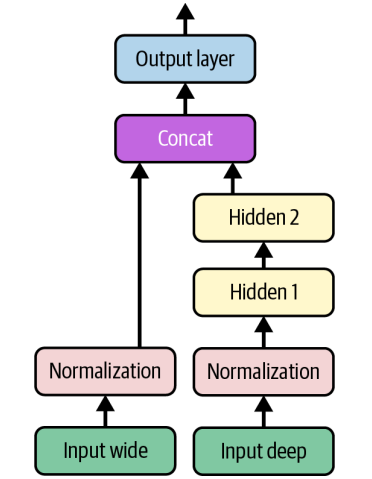

在这种情况下，一个解决方案是使用多个输入。例如，假设我们希望通过宽路径发送5个特征（特征0到4），以及通过深度路径发送6个特征（特征2到7）。

我们可以这样做：

In [41]:
input_wide = tf.keras.layers.Input(shape=[5]) # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6]) # features 2 to 7

norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()

norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

**本例中有几件事需要注意**:

1. 在同一行上创建并调用每个 Dense layer。这是一种常见的做法，因为它可以使代码更加简洁而不失去清晰度。然而，我们不能使用 Normalization layer 来做到这一点，因为我们需要对该层的引用，以便在拟合模型之前调用其 adapt() 方法。
2. 我们使用了 tf.keras.layers.concatenate() ，它创建了一个 Concatenate layer ，并使用给定的输入来调用它。
3. 在创建模型时，我们指定了输入=\[input_wide,input_deep \]，因为有两个输入。

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", 
              optimizer=optimizer, 
              metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)

history = model.fit((X_train_wide, X_train_deep),
                    y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))

mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.4101 - root_mean_squared_error: 1.1875 - val_loss: 0.5225 - val_root_mean_squared_error: 0.7229
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4693 - root_mean_squared_error: 0.6851 - val_loss: 1.1075 - val_root_mean_squared_error: 1.0524
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4233 - root_mean_squared_error: 0.6506 - val_loss: 0.3928 - val_root_mean_squared_error: 0.6267
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3947 - root_mean_squared_error: 0.6283 - val_loss: 0.9225 - val_root_mean_squared_error: 0.9605
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3788 - root_mean_squared_error: 0.6155 - val_loss: 0.7549 - val_root_mean_squared_error: 0.8688
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3721 - root_mean_squared_error: 0.6100 - val_loss: 0.7611 - val_

**在其他许多用例中可能需要有多个输出**：

1. 该任务可能需要它。例如，您可能希望定位和分类图片中的主要对象。这既是一个回归任务，也是一个分类任务。
2. 类似地，您可能基于相同的数据有多个独立的任务。当然，您可以为每个任务训练一个神经网络，但在许多情况下，对所有任务仅训练一个神经网络，您可以在所有任务上得到更好的结果。这是因为神经网络可以学习数据中跨任务有用的特征。例如，你可以对面部图片执行多任务分类，使用一个输出来分类这个人的面部表情（微笑、惊讶等）。还有另一个输出来识别他们是否戴着眼镜。
3. 另一个用例是作为一种正则化技术（即，一种训练约束，其目标是减少过拟合，从而提高模型的泛化能力）。例如，您可能希望在神经网络体系结构中添加一个辅助输出，以确保该系统中的底层网络自己学习一些有用的东西，而不依赖于网络的其他部分。

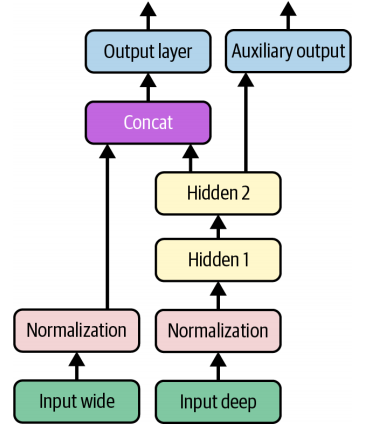

In [43]:
input_wide = tf.keras.layers.Input(shape=[5]) # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6]) # features 2 to 7

norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()

norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)

model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

每个输出都需要它自己的损失函数。因此，当我们编译模型时，我们应该通过一个损失列表。如果我们传递一个损失，Keras将假设所有输出都必须使用相同的损失。默认情况下，Keras将计算所有的损失，并简单地将它们加起来，从而得到用于训练的最终损失。由于我们更关心主输出而不是辅助输出（因为它只是用于正则化），所以我们希望给主输出的损失一个更大的权重。幸运的是，在编译模型时，可以设置所有的损失权重：

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), 
              loss_weights=(0.9, 0.1), 
              optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

现在，当我们训练模型时，我们需要为每个输出提供标签。在本例中，主输出和辅助输出应该尝试预测相同的事情，因此它们应该使用相同的标签。

In [45]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep),
    (y_train, y_train), 
    epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.1885 - dense_22_loss: 2.1869 - dense_23_loss: 2.2037 - dense_22_root_mean_squared_error: 1.4788 - dense_23_root_mean_squared_error: 1.4845 - val_loss: 3.8541 - val_dense_22_loss: 3.4507 - val_dense_23_loss: 7.4847 - val_dense_22_root_mean_squared_error: 1.8576 - val_dense_23_root_mean_squared_error: 2.7358
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6412 - dense_22_loss: 0.6227 - dense_23_loss: 0.8080 - dense_22_root_mean_squared_error: 0.7891 - dense_23_root_mean_squared_error: 0.8989 - val_loss: 1.9425 - val_dense_22_loss: 1.6128 - val_dense_23_loss: 4.9092 - val_dense_22_root_mean_squared_error: 1.2700 - val_dense_23_root_mean_squared_error: 2.2157
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5111 - dense_22_loss: 0.4967 - dense_23_loss: 0.6413 - dense_22_root_mean_squared_error: 0.7047 - dense_23_root_mean_squared_error: 0.8008 - val_loss: 0.740

In [46]:
# Keras返回损失的加权和，以及所有单独的损失和指标
eval_results = model.evaluate((X_test_wide, X_test_deep),
                              (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

162/162 [==============================] - 0s 834us/step - loss: 0.3356 - dense_22_loss: 0.3299 - dense_23_loss: 0.3860 - dense_22_root_mean_squared_error: 0.5744 - dense_23_root_mean_squared_error: 0.6213


如果设置return_dict=True，那么 evaluate() 将返回一个字典而不是一个大元组。

In [47]:
# predict() method will return predictions for each output
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 52ms/step


predict() 方法返回一个元组，并且它没有 return_dict 参数来获取字典。但是，可以使用 model.output_names 创建一个:

In [48]:
# create a dictionary using model.output_names
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 [==============================] - 0s 17ms/step


## 10. 使用子类化API来构建动态模型（Using the Subclassing API to Build Dynamic Models）

**sequential API和functional API都是声明性的**：首先声明要使用哪些层以及应该如何连接它们，只有这样，才能开始为模型提供一些数据，用于训练或推断。

这样做有很多优点：模型可以很容易地保存、克隆和共享；它的结构可以显示和分析；框架可以推断形状和检查类型，因此错误可以及早捕获（即，在任何数据通过模型之前）。调试也相当简单，因为整个模型是一个层的静态图。

但另一方面，它是静态的。一些模型涉及循环、不同的形状、条件分支和其他动态行为。对于这种情况，或者喜欢命令式的编程风格，**Subclassing API**就更适合。

使用这种方法，可以对Model类进行子类化，在构造函数中创建需要的层，并使用它们来执行 call() 方法中所需的计算。例如，创建以下WideAndDeepModel类的实例可以给我们一个与我们刚刚使用函数API构建的模型等价的模型：

In [112]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

model.call([input_wide,input_deep])

(<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_34')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_35')>)

这个API的最大区别是，可以在 call() 方法中包含几乎任何您想要的东西：**for**循环，**if**语句，低级的TensorFlow操作。这使得它成为了在试验新想法时的一个很好的API，特别是对研究人员来说。

然而，这种额外的灵活性确实是有代价的：您的模型的架构隐藏在 call() 方法中，所以Keras不能轻易地检查它；不能使用 tf.keras.models.clone_model() 克隆模型；当调用 summary() 方法时，只得到一个层列表，没有任何关于它们如何相互连接的信息。此外，Keras不能提前检查类型和形状，而且更容易出错。所以，除非你真的需要额外的灵活性，否则你应该坚持使用顺序API或功能API。

## 11. 保存和恢复模型（Saving and Restoring a Model）

In [49]:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model\assets


当设置 **save_format="tf"** 时，Keras使用TensorFlow的保存模型格式保存模型：这是一个包含几个目录的文件和子目录。

**saved_model.pb** 文件以序列化计算图的形式包含了模型的体系结构和逻辑，因此您不需要部署模型的源代码来在生产中使用它；SavedModel就足够了（将在第12章看到它是如何工作的）。 

**keras_metadata.pb** 文件包含了Keras所需的额外信息。

**variable** 目录包含所有的参数值（包括连接权重、偏差、规范化统计信息和优化器的参数），可能会跨越多个文件，如果模型非常大。

**assets** 目录可能包含额外的文件，如数据示例、特征名称、类名等。默认情况下，asset 目录为空。由于优化器也被保存了，包括它的超参数和它可能具有的任何状态，因此在加载模型之后，如果需要，可以继续训练。

如果设置了 **save_format="h5"** 或使用以 **.h5** 、**.hdf5** 或 **.keras** 结尾的文件名，那么Keras将使用基于HDF5格式的Keras特定格式将模型保存到单个文件中。无论如何，大多数拉伸流部署工具都需要保存模型格式来代替。

通常会有一个训练并保存模型的脚本，以及一个或多个加载模型并使用它来评估或进行预测的脚本（或web服务）。**加载模型和保存模型一样简单**：

In [50]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 60ms/step


还可以使用 **save_weight()** 和 **load_weights()** 来只保存和加载参数值。这包括连接权重、偏差、预处理统计数据、优化器状态等。参数值保存在一个或多个文件中，如my_weights.data-00004-of-00052，以及一个索引文件，如my_weights.index。

仅仅保存 weights 比节省整个 model 更快，使用更少的磁盘空间，所以在训练过程中保存 quick checkpoints 是必要的。如果你正在训练一个大型模型，而这需要数个小时或数天，那么你必须定期保存 checkpoints ，以防电脑崩溃。

## 12. 使用回调（Using Callbacks）

fit() 方法接受一个 callbacks 参数，该参数允许指定Keras在训练之前和之后、每个epoch之前和之后、甚至在每个批处理之前和之后调用的对象列表。例如，ModelCheckpoint 回调在训练期间定期保存模型的检查点，默认情况下是在每个epoch结束时：

In [51]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
history = model.fit((X_train_wide, X_train_deep),
                    (y_train, y_train), 
                    epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
                    callbacks=[checkpoint_cb])

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3405 - dense_22_loss: 0.3345 - dense_23_loss: 0.3943 - dense_22_root_mean_squared_error: 0.5784 - dense_23_root_mean_squared_error: 0.6279 - val_loss: 0.3978 - val_dense_22_loss: 0.4004 - val_dense_23_loss: 0.3740 - val_dense_22_root_mean_squared_error: 0.6328 - val_dense_23_root_mean_squared_error: 0.6115
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3339 - dense_22_loss: 0.3283 - dense_23_loss: 0.3842 - dense_22_root_mean_squared_error: 0.5730 - dense_23_root_mean_squared_error: 0.6199 - val_loss: 0.7570 - val_dense_22_loss: 0.6836 - val_dense_23_loss: 1.4171 - val_dense_22_root_mean_squared_error: 0.8268 - val_dense_23_root_mean_squared_error: 1.1904
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3402 - dense_22_loss: 0.3344 - dense_23_loss: 0.3922 - dense_22_root_mean_squared_error: 0.5783 - dense_23_root_mean_squared_error: 0.6263 - val_loss: 0.520

此外，如果在训练期间使用验证集，则可以在创建模型检查点时设置 **sase_best_only=True** 。在这种情况下，只有在验证集上的性能到目前为止最好时，它才会保存您的模型。这样，就不需要担心太长时间的训练和过拟合训练集：只需在训练后恢复最后保存的模型，这将是验证集上的最佳模型。这是实现早期停止的一种方法，但实际上并不会停止训练。

另一种方法是使用 EarlyStopping 回调。当它在许多epoch（由 patience 参数定义）的验证集上没有进展时，它将中断训练，如果你设置 **restore_best_weights=True** ，它将在训练结束时回滚到最佳模型。您可以结合这两种回调来保存模型的检查点，以防您的计算机崩溃，并在没有更多的进展时尽早中断训练，以避免浪费时间和资源，并减少过拟合：

In [52]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit((X_train_wide, X_train_deep),
                    (y_train, y_train), 
                    epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3148 - dense_22_loss: 0.3097 - dense_23_loss: 0.3603 - dense_22_root_mean_squared_error: 0.5565 - dense_23_root_mean_squared_error: 0.6002 - val_loss: 0.4000 - val_dense_22_loss: 0.4008 - val_dense_23_loss: 0.3936 - val_dense_22_root_mean_squared_error: 0.6331 - val_dense_23_root_mean_squared_error: 0.6274
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3200 - dense_22_loss: 0.3151 - dense_23_loss: 0.3641 - dense_22_root_mean_squared_error: 0.5613 - dense_23_root_mean_squared_error: 0.6034 - val_loss: 0.7075 - val_dense_22_loss: 0.6851 - val_dense_23_loss: 0.9088 - val_dense_22_root_mean_squared_error: 0.8277 - val_dense_23_root_mean_squared_error: 0.9533
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3176 - dense_22_loss: 0.3126 - dense_23_loss: 0.3625 - dense_22_root_mean_squared_error: 0.5591 - dense_23_root_mean_squared_error: 0.6020 - val_loss: 0.326

epoch 的数量可以设置为一个很大的值，因为当训练没有更多的进展时，训练就会自动停止（只要确保学习速度不是太小，否则它可能会持续缓慢，直到结束）。EarlyStopping 回调将在RAM中存储最佳模型的权重，并将在训练结束时为您恢复它们。

**如果需要额外的控制，可以轻松地编写您自己的自定义回调**。

例如，下面的自定义回调将显示验证损失和训练期间的训练损失之间的比率（例如，检测过拟合）：

In [53]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

也可以应用on_train_begin(), on_train_end(), on_epoch_begin(), on_epoch_end(), on_batch_begin(), and on_batch_end()。

如果需要(例如，也可以在评估和预测中使用回调（用于调试）：

1. 对于 evaluation，应该实现on_test_begin()，on_test_end()，on_test_batch_begin()，或 on_test_batch_end()，通过 evaluate() 调用。
2. 对于 prediction，应该实现on_predict_begin()，on_predict_end()，on_predict_batch_begin()，或 on_predict_batch_end()，通过 predict() 调用。

## 13. 使用 TensorBoard 进行可视化（Using TensorBoard for Visualization）

TensorBoard 是一个交互式可视化工具，你可以用来查看学习曲线训练，比较曲线和指标之间的多次运行，可视化计算图，分析训练统计数据，查看图像生成的模型，可视化复杂的多维数据投影到3D和自动集群，配置你的网络（即，测量其速度来识别瓶颈）等。

要使用TensorBorad，您必须修改您的程序，使其将您想要可视化的数据输出到称为**events file**的特殊二进制日志文件中。每个二进制数据记录都被称为**summary**。TensorBorad服务器将监控日志目录，它将自动接收更改并更新可视化：这允许您可视化实时数据（有一个短的延迟），例如在训练期间的学习曲线。通常，希望将TensorBorad服务器指向一个根日志目录，并配置程序，使其在每次运行时都写入一个不同的子目录。通过这种方式，相同的TensorBoard服务器实例将允许您可视化和比较来自程序多次运行的数据，而不会将所有内容混淆。

让我们将根日志目录命名为my_logs，并定义一个小函数，它根据当前日期和时间生成日志子目录的路径，这样在每次运行时都不同：

In [54]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir() # e.g., my_logs/run_2022_08_01_17_25_59

run_logdir

WindowsPath('my_logs/run_2023_01_09_11_46_02')

好消息是，Keras提供了一个方便的 **TensorBoard()** 回调，它将负责为您创建日志目录（如果需要的话，还有它的父目录），并且它将在培训期间创建事件文件并向它们编写摘要。它将测量您的模型的训练和验证损失和指标（在本例中，是MSE和RMSE），并且它还将描述您的神经网络。它使用起来很简单：

In [55]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))

history = model.fit((X_train_wide, X_train_deep),
                    (y_train, y_train), 
                    epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
                    callbacks=[tensorboard_cb])

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3047 - dense_22_loss: 0.2998 - dense_23_loss: 0.3490 - dense_22_root_mean_squared_error: 0.5476 - dense_23_root_mean_squared_error: 0.5907 - val_loss: 0.3463 - val_dense_22_loss: 0.3394 - val_dense_23_loss: 0.4088 - val_dense_22_root_mean_squared_error: 0.5826 - val_dense_23_root_mean_squared_error: 0.6393
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3075 - dense_22_loss: 0.3028 - dense_23_loss: 0.3495 - dense_22_root_mean_squared_error: 0.5503 - dense_23_root_mean_squared_error: 0.5912 - val_loss: 0.7294 - val_dense_22_loss: 0.7142 - val_dense_23_loss: 0.8654 - val_dense_22_root_mean_squared_error: 0.8451 - val_dense_23_root_mean_squared_error: 0.9303
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3061 - dense_22_loss: 0.3014 - dense_23_loss: 0.3486 - dense_22_root_mean_squared_error: 0.5490 - dense_23_root_mean_squared_error: 0.5904 - val_loss: 0.307

在这个例子中，它将在第一个 epoch 描述 batches 100 和 200 之间的网络。为什么是100个和200个？神经网络通常需要一些 batches 来“热身”，所以你不想太早地分析并且分析使用资源，所以最好不要每个batch都这样做。

接下来，尝试将学习速率从0.001更改为0.002，然后使用一个新的日志子目录再次运行该代码。您将得到一个类似的目录结构：

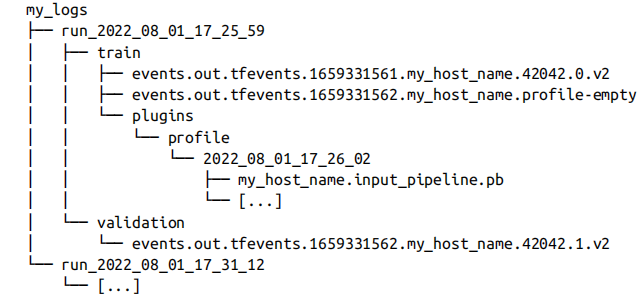

每次运行都有一个目录，每个目录包含一个用于训练日志的子目录和一个用于验证日志的子目录。两者都包含事件文件，培训日志还包括分析跟踪。

现在已经准备好了event files，那么是时候启动 TensorBoard 服务器了。这可以直接在 Jupyter 或 Colab 中使用 Jupyter 的 TensorBoard 扩展来完成，它与 TensorBorad 库一起安装。此扩展已预装在Colab中。下面的代码加载了 TensorBoard 的Jupyter扩展，第二行为 my_logs 目录启动了一个 TensorBoard 服务器，连接到这个服务器，并直接在 Jupyter 内部显示用户界面。该服务器将侦听大于或等于6006的第一个可用TCP端口（或者您可以使用——端口选项设置所需的端口）。

In [69]:
%reload_ext tensorboard

In [70]:
# http://localhost:6006 to another page...
%tensorboard --logdir=./my_logs/

现在应该看到拉伸板的用户界面。单击 SCALARS 选项卡以查看学习曲线。在左下角，选择要可视化的日志（例如，第一次和第二次运行时的训练日志），并单击epoch_loss标量。注意，在两次运行中，训练损失都下降得很好，但在第二次运行中，由于更高的学习率，它下降得更快一些。

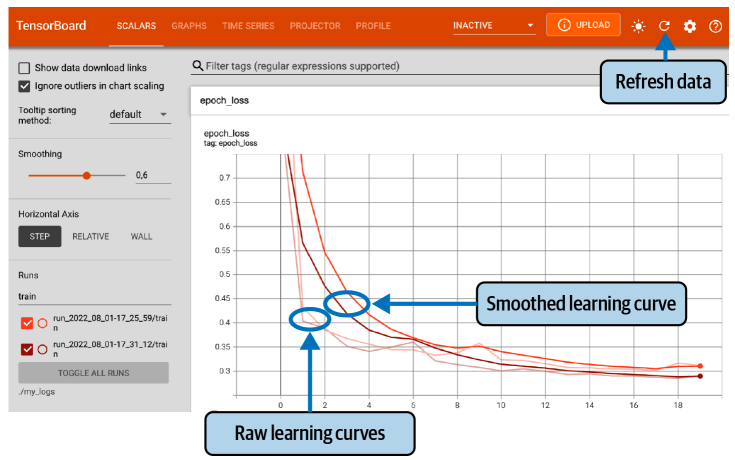

还可以在 GRAPHS 选项卡中可视化整个计算图，PROJECTOR 选项卡中的学习权重，以及 PROFILE 选项卡中的轮廓轨迹。TensorBoard() 回调也有记录额外数据的选项。您可以单击右上方的刷新按钮（⟳）来刷新 TensorBoard 数据，可以单击设置按钮（⚙）来激活自动刷新并指定刷新间隔。

此外，TensorFlow 在 tf.summary 包中提供了一个较低级的API。下面的代码使用 create_file_writer() 函数创建一个 SummaryWriter ，它使用这个编写器作为Python上下文来记录标量、直方图、图像、音频和文本，所有这些都可以使用张板可视化：

In [73]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100 # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000 # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

如果您运行此代码并单击 TensorBoard 中的刷新按钮，您将会出现几个选项卡：IMAGES、AUDIO、DISTRIBUTIONS、HISTOGRAMS和TEXT。尝试单击 IMAGES 选项卡，并使用每个图像上方的滑块来查看不同时间步长的图像。类似地，转到AUDIO选项卡，并尝试在不同的时间步长上收听音频。正如你所看到的，张量板是一个有用的工具，甚至超出了 TensorFlow 或 deep learning。

## 14. 微调神经网络超参数（Fine-Tuning Neural Network Hyperparameters）

神经网络的灵活性也是它们的主要缺点之一：有许多超参数需要调整。不仅可以使用任何网络架构，而且可以在基础MLP中改变层的数量，神经元的数量和使用在每一层中激活函数的类型，权重初始化逻辑，优化器使用的类型，学习率，批大小等等。

**如何知道哪种超参数组合最适合您的任务?**

一种选择是将您的Keras模型转换为一个Scikit-Learn估计器，然后使用 **GridSearchCV** 或 **RandomizedSearchCV** 来微调超参数。为此，您可以使用SciKeras库中的 **KerasRegressor** 和 **KerasClassifier** 包装器类。

但是，有一个更好的方法：您可以使用 **Keras Tuner**，这是一个针对Keras模型的超参数调优库。它提供了几种调优策略，它是高度可定制的，并且它与 TensorBoard 有良好的集成。

导入 keras_tuner ，通常as kt，然后编写一个函数来构建、编译和返回一个Keras模型。该函数必须取一个 **kt.HyperParameters** 对象作为一个参数，它可以使用它来定义超参数（integers、floats、strings等）以及它们可能的值的范围，这些超参数可以用来构建和编译模型。

例如，下面的函数构建并编译一个MLP，使用隐藏层数（n_hidden），每层神经元数（n_neurons）、学习速率（learning_rate）和该速率使用的优化器类型（optimizer）来处理Fashion MNIST图像：

In [76]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model

该函数的第一部分定义了超参数。例如，**hp.Int("n_hidden", min_value=0, max_value=8, default=2)** 检查一个名为“**n_hidden**”的超参数是否已经出现在超参数对象 hp 中，如果是，它将返回其值。如果没有，那么它注册一个名为“**n_hidden**”的新整数超参数，其可能值范围从0到8（包括），并且它返回默认值，在这种情况下为2（当没有设置默认值时，则返回min_value）。“**n_neurons**”超参数也以类似的方式进行注册。“**learning_rate**”超参数被注册为一个从 $10^{-4}$ 到 $10^{-2}$ 的浮点数，由于 sampling="log"，所有尺度的学习率将被等量采样。最后，**optimizer** 超参数注册了两个可能的值：“sgd”或“adam”（默认值是第一个，在本例中是“sgd”）。根据优化器的值，我们创建了一个具有给定学习率的SGD优化器或Adam优化器。

该函数的第二部分只是使用超参数值来构建模型。它创建一个从 Flatten layer 开始的顺序模型，然后使用ReLU激活函数请求的隐藏层数（由 n_hidden 超参数确定），并使用softmax激活函数创建包含10个神经元（每类一个）的输出层。最后，该函数将编译该模型并返回该模型。

现在，如果想做一个基本的随机搜索，你可以创建一个 **kt.RandomSearch** tuner，将build_model函数传递给构造函数，并调用 tuner 的 **search()** 方法：

In [77]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)

random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 05s]
val_accuracy: 0.004392764996737242

Best val_accuracy So Far: 0.004651162773370743
Total elapsed time: 00h 00m 25s
INFO:tensorflow:Oracle triggered exit


RandomSearch tuner首先用一个空的超参数对象调用 build_model() 一次，只是为了收集所有的超参数规范。然后，在这个例子中，它运行5次试验；对于每个试验，它使用在各自范围内随机抽样的超参数建立一个模型，然后训练该模型10个epoch，并将其保存到 my_fashion_mnist/my_rnd_search 目录的子目录中。由于 **overwrite=True** ，my_rnd_search目录在训练开始之前被删除。如果你第二次运行这段代码，但 **overwrite=False** 和 **max_trials=10** ，调谐器将从它停止的地方继续调优，再运行5个试验：这意味着你不必在一次运行所有试验。最后，由于目标被设置为“**val_accuracy**”，调谐器更喜欢具有更高验证精度的模型，所以一旦调谐器完成了搜索，你就可以得到像这样的最佳模型：

In [78]:
top3_models = random_search_tuner.get_best_models(num_models=3)

best_model = top3_models[0]

可以调用 get_best_hyperparameters() 来获取的最佳模型的  kt.HyperParameters ：

In [79]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)

top3_params[0].values

{'n_hidden': 5,
 'n_neurons': 25,
 'learning_rate': 0.0006562536901904111,
 'optimizer': 'adam'}

每个 tuner 都由一个所谓的 oracle 指导：在每次试验之前，tuner 要求 oracle 告诉它下一次试验应该是什么。RandomSearch tuner 使用了一个 RandomSearch Oracle ，这是非常基本的：它只是随机选择下一个试验，就像我们之前看到的那样。因为 oracle 会跟踪所有的试验，你可以要求它给你最好的一个，你可以显示该试验的摘要：

In [80]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]

best_trial.summary()

Trial summary
Hyperparameters:
n_hidden: 5
n_neurons: 25
learning_rate: 0.0006562536901904111
optimizer: adam
Score: 0.004651162773370743


这显示了最佳的超参数（如前面提到的那样），以及验证的精度。您还可以直接访问所有指标：

In [81]:
best_trial.metrics.get_last_value("val_accuracy")

0.004651162773370743

如果您对最佳模型的性能感到满意，您可以在完整的训练集（X_train_full和y_train_full）上继续训练它几个epoch，然后在测试集上评估它，并将其部署到生产中（见第19章）：

In [82]:
best_model.fit(X_train_full, y_train_full, epochs=10)

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
484/484 [==============================] - 1s 877us/step - loss: 1.7373 - accuracy: 0.0025
Epoch 2/10
484/484 [==============================] - 0s 1ms/step - loss: 1.6914 - accuracy: 0.0032
Epoch 3/10
484/484 [==============================] - 0s 904us/step - loss: 1.6420 - accuracy: 0.0032
Epoch 4/10
484/484 [==============================] - 0s 903us/step - loss: 1.5999 - accuracy: 0.0027
Epoch 5/10
484/484 [==============================] - 0s 1ms/step - loss: 1.5587 - accuracy: 0.0030
Epoch 6/10
484/484 [==============================] - 0s 924us/step - loss: 1.4795 - accuracy: 0.0028
Epoch 7/10
484/484 [==============================] - 0s 878us/step - loss: 1.4000 - accuracy: 0.0031
Epoch 8/10
484/484 [==============================] - 0s 1ms/step - loss: 1.3564 - accuracy: 0.0028
Epoch 9/10
484/484 [==============================] - 0s 938us/step - loss: 1.2924 - accuracy: 0.0028
Epoch 10/10
162/162 [==============================] - 0s 705us/step - loss: 1.3236 - ac

在某些情况下，您可能需要调整数据预处理超参数，或 **model.fit()** 参数，例如批处理大小。为此，必须使用一种稍微不同的技术：不能编写一个build_model()函数，而是必须对 kt.HyperModel 类进行子类化并定义两种方法，build() 和 fit() 。build() 方法与 build_model() 函数做了完全相同的事情。fit() 方法将超参数对象和编译的模型作为参数，以及所有模型。fit() 参数，拟合模型并返回历史对象。至关重要的是，fit() 方法可以使用超参数来决定如何预处理数据、调整批处理大小等等。

例如，下面的类构建了与以前相同的模型，使用相同的超参数，但它也使用一个 Boolean “normalize” 超参数来控制在拟合模型之前是否标准化训练数据：

In [83]:
class MyClassificationHyperModel(kt.HyperModel):

    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

然后，您可以将此类的实例传递给您选择的 tuner ，而不是传递 build_model 函数。

例如，让我们基于一个 MyClassificationHyperModel 实例构建一个 kt.Hyperband tuner：

In [84]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

这个 tuner 类似于我们在第2章中讨论的 HalvingRandomSearchCV 类：它开始在几个epoch训练许多不同的模型，然后它消除最坏的模型，只保留前 1/factor 个模型(即该例中前三个）。重复这个选择过程，直到只剩下一个模型为止。max_epochs 参数控制了最佳模型将被训练的最大epoch。在这种情况下，整个过程重复了两次（hyperband_iterations=2）。每个 hyperband iteration 的所有模型的训练 epoch 总数大约是 $max\_epochs \times ( \frac{log(max\_epochs)}{log(factor)} )^2$，所以在本例中大约是44个周期。其他参数与 kt.RandomSearch 相同。

现在让我们运行 Hyperband tuner 。我们将使用 TensorBoard 回调，这次指向根日志目录（tuner 将负责为每个试验使用不同的子目录），以及一个 EalryStopping 回调：

In [85]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"

tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)

hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 02s]
val_accuracy: 0.004392764996737242

Best val_accuracy So Far: 0.004909560550004244
Total elapsed time: 00h 02m 34s
INFO:tensorflow:Oracle triggered exit


现在，如果你打开 TensorBoard ，指向 --logdir 到 my_fashion_mnist/hyperband/tensorboard 目录，你将看到所有的试验结果的展开。确保访问 **HPARAMS** 选项卡：它包含了已尝试过的所有超参数组合的摘要，以及相应的指标。

请注意，在 HPARAMS 选项卡中有三个选项卡：表视图、平行坐标视图和散点图矩阵视图。在左侧面板的下方，取消选中除 validation.epoch_accuracy 之外的所有指标：这将使图表更清晰。在平行坐标视图中，尝试在validation.epoch_accuracy列中选择一个高值的范围：这将只过滤达到良好性能的超参数组合。单击其中一个超参数组合，相应的学习曲线将出现在页面的底部。花一些时间浏览每个选项卡；这将有助于您了解每个超参数对性能的影响，以及超参数之间的相互作用。

Hyperband 在分配资源的方式上比纯随机搜索更智能，但其核心仍然是随机探索超参数空间；它很快，但很粗糙。然而，Keras Tuner 也包括一个 kt.BayesianOptimization tuner：该算法通过拟合一个称为高斯过程的概率模型，逐渐学习超参数空间的哪些区域最有前途。这使得它可以逐渐放大最佳的超参数。缺点是该算法有自己的超参数： **alpha** 代表你在试验的性能测量中期望的噪声水平（默认为10-4），**beta** 指定了你希望算法探索多少，而不是简单地利用超参数空间的已知良好区域（默认为2.6）。除此之外，这个 tuner 可以像以前的一样使用：

In [86]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")

bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 00m 04s]
val_accuracy: 0.004392764996737242

Best val_accuracy So Far: 0.004909560550004244
Total elapsed time: 00h 00m 55s
INFO:tensorflow:Oracle triggered exit


超参数调优仍然是一个活跃的研究领域，还有许多其他的方法正在探索之中。例如，DeepMind2017年的优秀论文，作者使用进化算法联合优化了一群超元素及其超参数。谷歌还使用了一种进化的方法，不仅搜索超参数，还探索各种模型架构：它支持谷歌Vertex AI上的AutoML服务（见第19章）。术语AutoML指的是处理ML工作流的大部分内容的任何系统。进化算法甚至已经被成功地用于训练单个的神经网络，取代了无处不在的梯度下降！例如，Uber 2017年的文章，作者介绍了他们的深度神经进化技术。

但是，尽管取得了这些令人兴奋的进展和所有这些工具和服务，了解每个超参数的值是合理的，这样您就可以构建一个快速的原型并限制搜索空间。下面的部分提供了选择MLP中隐藏层和神经元的数量以及为一些主要超参数选择良好的值的指导方针。

## 15. 隐藏图层的数量（Number of Hidden Layers）

对于许多问题，可以从一个隐藏层开始，并得到合理的结果。一个只有一个隐藏层的MLP理论上可以模拟最复杂的函数，只要它有足够的神经元。但对于复杂的问题，深度网络比浅网络的 参数效率（parameter efficiency） 高得多：它们可以使用比浅网络少的神经元来建模复杂函数，使它们在相同的训练数据下达到更好的性能。

要理解原因，假设您被要求使用一些绘图软件绘制一个森林，但禁止您复制和粘贴任何东西。这需要花费大量的时间：你必须把每棵树单独画出来，一根一根地画出来，一根一根地画出来。如果你可以画一个叶子，复制和粘贴它来绘制一个分支，然后复制和粘贴这个分支来创建一个树，最后复制和粘贴这棵树来形成一个森林，你就会很快完成。真实世界的数据以这种分层的方式通常是结构化的，深度神经网络自动利用这一事实：低隐藏层建模低级结构（如各种形状和方向的线段），中间隐藏层结合这些低级结构来建模中级结构（如正方形、圆形），最高隐藏层和输出层将这些中间结构组合来建模高级结构（如面）。

这种分层结构不仅帮助 DNN 更快地收敛到一个好的解决方案，而且还提高了它们泛化到新数据集的能力。例如，如果你已经训练了一个模型来识别图片中的人脸，而现在你想要训练一个新的神经网络来识别发型，你可以通过重用第一个网络的下层来开始训练。可以不必随机初始化新的神经网络的前几层的权值和偏差，而是将它们初始化为第一个网络的较低层的权值和偏差的值。这样，网络就不需要从头开始学习大多数图片中出现的所有低级结构；它只需要学习更高层次的结构（例如，发型）。这叫做 **迁移学习（transfer learning）** 。

总之，对于许多问题，你可以从一两个隐藏层开始，神经网络可以工作得很好。例如，在MNIST数据集上，只使用一个包含几百个神经元的隐藏层，就可以很容易地达到97%以上的准确率，而使用两个具有相同神经元总数的隐藏层，则可以达到98%以上的准确率。对于更复杂的问题，您可以增加隐藏层的数量，直到您开始过拟合训练集。非常复杂的任务，如大型图像分类或语音识别，通常需要几十层的网络（甚至数百层，但不是完全连接的网络，你将在第14章中看到），而且它们需要大量的训练数据。你很少需要从头开始训练这样的网络：更常见的是重用执行类似任务的最先进的网络的部分。培训将会更快，需要的数据也会更少（我们将在第11章中讨论）。

## 16. 每个隐藏层的神经元数量

输入和输出层中的神经元数量取决于任务所需的输入和输出类型。例如，MNIST任务需要28个×28个= 784个输入和10个输出神经元。

对于隐藏层，过去通常将它们的大小形成金字塔，每一层的神经元越来越少——其原理是许多低级特征可以合并成更少的高级特征。一个典型的MNIST神经网络可能有3个隐藏层，第一层有300个神经元，第二个有200个神经元，第三层有100个神经元。然而，这种做法在很大程度上已经被放弃了，因为在大多数情况下，在所有隐藏层中使用相同数量的神经元效果相同，甚至更好；另外，只有一个超参数要调整，而不是每层一个。也就是说，根据数据集的不同，它有时可以帮助使第一个隐藏层比其他隐藏层更大。

就像层数一样，你也可以尝试逐步增加神经元的数量，直到网络开始过拟合。或者，您可以尝试构建一个比实际需要的稍微多一些的层和神经元的模型，然后使用早期停止和其他正则化技术来防止它过度拟合。谷歌的科学家文森特·范胡克称这种方法为“弹力裤”：不要浪费时间寻找完全适合你尺寸的裤子，只要使用可以缩小到合适尺寸的大弹力裤就行了。使用这种方法，您可以避免破坏模型的瓶颈层。事实上，如果一个层的神经元太少，它就没有足够的表示能力来保存输入的所有有用信息（例如，有两个神经元的层只能输出二维数据，所以如果它得到三维数据作为输入，一些信息就会丢失）。无论网络的其他部分有多大和强大，这些信息都永远不会被恢复。

**一般来说，通过增加层数而不是每层的神经元数来获得更多的回报**。

## 17. 学习速率、批处理大小和其他超参数

隐藏层和神经元的数量并不是在MLP中调整的唯一超参数。以下是一些最重要的超参数，以及关于如何设置它们的提示：
1. **学习率（learning rate）**：学习速率可以说是最重要的超参数。一般来说，最优学习率大约是最大学习率（训练算法不收敛的学习率）的一半。找到一个好的学习率的一种方法是对模型进行几百个迭代的训练，从一个非常低的学习率开始（例如，$10^{-5}$），然后逐渐增加到一个非常大的值（例如，10）。这是通过在每次迭代中将学习速率乘以一个常数因子（例如 $(\frac{10}{10^{-5}})^{frac{1}{500}}$ ，在500次迭代中从10-5到10）。如果损失绘制为学习率的函数（使用对数尺度表示学习率），那么首先应该会看到它在下降。但过一段时间，学习率会太大，所以损失会重新上升：最佳学习率将比损失开始上升的点低一点（通常比转折点低10倍）。然后，您可以重新初始化您的模型，并使用这个良好的学习率正常地训练它。我们将在第11章中介绍更多的学习率优化技术。
2. **优化器（Optimizer）**：选择一个比朴素且过时的小批量梯度下降（并调整其超参数）更好的优化器也非常重要。我们将在第11章中研究几个高级优化器。
3. **批大小（Batch size）**：批处理的大小可能会对模型的性能和训练时间产生显著影响。使用大批处理的主要好处是，像GPU这样的硬件访问器可以有效地处理它们（见第19章），因此训练算法每秒会看到更多的实例。因此，许多研究人员和从业者建议使用适合GPU RAM的最大批大小。不过，这里有一个问题：在实际中，大批量通常会导致训练不稳定，特别是在训练开始时，所产生的模型可能不会像小批量训练的模型那样泛化。2018年4月，扬勒村甚至在推特上“朋友不让朋友使用大于32的小批量”，引用2018年多米尼克大师和卡洛的论文得出结论，使用小批量（从2到32）是可取的，因为小批量导致更好的模型在更少的训练时间。然而，其他的研究则指向相反的方向。例如，在2017年，论文Elad Hoffer等和Priya Goyal等表明，可以使用非常大的批规模（8192）以及各种技术如热身学习率（即开始训练小学习率，然后提高，第11章中讨论）和获得非常短的训练时间，没有任何泛化差距。所以，一种策略是尝试使用大的批量，学习率预热，如果训练不稳定或最终的表现令人失望，那么尝试使用小批量代替。
4. **激活函数（Activation function）**：我们在本章前面讨论了如何选择激活函数：一般来说，ReLU激活函数对于所有隐藏层都是一个很好的默认值，但对于输出层，它实际上取决于您的任务。
5. **迭代次数（Number of iterations）**：在大多数情况下，训练迭代的数量实际上不需要调整：只使用早期停止。

**最佳学习速率取决于其他超参数——特别是批处理大小——所以如果您修改了任何超参数，请确保也更新了学习速率。**